In [1]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load HCP acqusition scheme 
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [3]:
#set up the models - this would be done before calling the fitting function in dmipy 

 
#ballstick
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

stick = cylinder_models.C1Stick()
ball = gaussian_models.G1Ball()

ballstick = MultiCompartmentModel(models=[ball,stick])

print(ballstick.parameter_names)
print(ballstick.parameter_ranges)



#NODDI-Watson 
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])
#set tortuous parameters
watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)
#put the model together
from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

print(NODDI.parameter_names)
print(NODDI.parameter_ranges)


    

We highly recommend installing pathos to take advantage of multicore processing.
['C1Stick_1_lambda_par', 'C1Stick_1_mu', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1']
OrderedDict([('C1Stick_1_lambda_par', (0.1, 3)), ('C1Stick_1_mu', ([0, 3.141592653589793], [-3.141592653589793, 3.141592653589793])), ('G1Ball_1_lambda_iso', (0.1, 3)), ('partial_volume_0', (0.01, 0.99)), ('partial_volume_1', (0.01, 0.99))])
We highly recommend installing pathos to take advantage of multicore processing.
['SD1WatsonDistributed_1_SD1Watson_1_mu', 'SD1WatsonDistributed_1_partial_volume_0', 'SD1WatsonDistributed_1_SD1Watson_1_odi', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1']
OrderedDict([('SD1WatsonDistributed_1_SD1Watson_1_mu', ([0, 3.141592653589793], [-3.141592653589793, 3.141592653589793])), ('SD1WatsonDistributed_1_partial_volume_0', (0.01, 0.99)), ('SD1WatsonDistributed_1_SD1Watson_1_odi', (0.02, 0.99)), ('G1Ball_1_lambda_iso', (0.1, 3)), ('partial_volume_0', (0.01,

In [4]:
#simulate a test image using ball stick model

dimx=10
dimy=10
simimg = np.zeros((dimx,dimy,acq_scheme.number_of_measurements))
nparam=6
param_map = np.zeros((dimx,dimy,nparam))

mu_min = np.array([0,-np.pi])
mu_max = np.array([np.pi,np.pi])

#mu_min = np.array([1.5,2])
#mu_max = np.array([1.5,2])

lambda_par_min = 1e-9
lambda_par_max = 2e-9

lambda_iso_min = 1.5e-9
lambda_iso_max = 3e-9

f_0_min = 0.1
f_0_max = 0.9

for x in range(0,dimx):
    for y in range(0,dimy):
        #random parameters
        #mu = np.random.uniform(low=[0,-np.pi],high=[np.pi,np.pi]) 
        #lambda_par = np.random.uniform(low=1e-9,high=2e-9) # in m^2/s
        #lambda_iso = np.random.uniform(low=1.5e-9,high=3e-9)  # in m^2/s
        #f_0 = np.random.uniform(low=0,high=1)
        
        #gradually changing parameters                
        mu = mu_min + [x/(dimx - 1),y/(dimy - 1)] * (mu_max - mu_min)        
        lambda_par = lambda_par_min + (x/(dimx-1)) * (lambda_par_max - lambda_par_min) # in m^2/s
        lambda_iso = lambda_iso_min + (y/(dimy-1)) * (lambda_iso_max - lambda_iso_min) # in m^2/s
        f_0 = f_0_min + (y/(2*(dimy-1))) * f_0_max + (x/(2*(dimx-1))) * (f_0_max - f_0_min)
        
        f_1 = 1-f_0

        parameter_vector = ballstick.parameters_to_parameter_vector(
            C1Stick_1_mu = mu,
            C1Stick_1_lambda_par=lambda_par, 
            G1Ball_1_lambda_iso=lambda_iso,
            partial_volume_0 = f_0,
            partial_volume_1 = f_1)

        #simulate this voxel
        nmeas = len(acq_scheme.bvalues)
        E = ballstick.simulate_signal(acq_scheme, parameter_vector)

        simimg[x,y,:] = E
        #simimg[x,y,:] = E + np.random.normal(0,0.01,nmeas) 
        
        param_map[x,y,:]=[mu[0],mu[1],lambda_iso,lambda_par,f_0,f_1]
        
        




In [5]:
#Attempt at MCMC for a general microstructural model

#FUNCTION INPUTS
#choose ballstick or NODDI for the two examples
model = NODDI
acq_scheme = acq_scheme
data = simimg
mask = simimg[..., 0]>0




import numpy as np
import scipy.stats
import copy
import matplotlib.pyplot as plt
import time
import math

#do the model fit with least squares to get initial values
lsq_fit = model.fit(acq_scheme, data, mask=mask)

#rearrange the least squares fitted parameters into initial arrays for the MCMC
lsq_fitted_parameters = lsq_fit.fitted_parameters

lsq_fit.fitted_parameters.keys()

#initial voxel-wise estimates from LSQ fits within the mask
#original
#D0_init = lsq_fitted_parameters['C1Stick_1_lambda_par'][mask]
#D1_init = lsq_fitted_parameters['G1Ball_1_lambda_iso'][mask]
#f0_init = lsq_fitted_parameters['partial_volume_0'][mask]
#f1_init = lsq_fitted_parameters['partial_volume_1'][mask]
#stick_ori_init = lsq_fitted_parameters['C1Stick_1_mu'][mask]
#for general model - using model.parameter_names
#initialise dictionary
init_param=dict.fromkeys(model.parameter_names)
for param in model.parameter_names:
    init_param[param] = lsq_fitted_parameters[param][mask]
    

# original - flatten params to get [5 x nvox] array
#params_all = np.array([D0_init,
#                       D1_init,
#                       f0_init,
#                       stick_ori_init[:,0],
#                      stick_ori_init[:,1]])

# general model - flatten params to get [nparam x nvox] array, with paramters in the correct order
#get the total number of independent parameters - accounting for both orientation parameters 
all_model_param_names = '\t'.join(model.parameter_names)
n_orient_params = all_model_param_names.count('_mu')
nparam = len(model.parameter_names) + n_orient_params 

#one of the volume fractions for multi-compartment models is not independent
#if allparam_names.count('partial_volume')==0:
#    ncomp=1
#else:
#    ncomp = allparam_names.count('partial_volume')
#nparam = len(model.parameter_names) + n_orient_params - (ncomp-1)


#extract some useful values
nvox = np.sum(mask)

params_all = np.empty([nparam,nvox])
#find the positions that are volume fractions
partial_volume_index = []

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        params_all[l:l+2,:] = np.transpose(init_param[param])
        l=l+2
    elif 'partial_volume_' in param: 
        partial_volume_index.append(l) #need to know the index of volume fractions for the MH proposal step
        
        params_all[l,:] = np.transpose(init_param[param])
        l=l+1       
    else: 
        params_all[l,:] = np.transpose(init_param[param])
        l=l+1

         

#get the initial E_sim, E_fit

#original
# dimx=nvox
# dimy=1
# nmeas = len(acq_scheme.bvalues)

# E_sim = np.zeros((dimx, dimy, nmeas))
# E_sim[:,0,:] = data[mask]

# E_fit = np.zeros((dimx, dimy, nmeas))
# for x in range(0, dimx):
#     for y in range(0,dimy):
#         # generate signal
#         #parameter_vector = model.parameters_to_parameter_vector(
#         #    C1Stick_1_mu=stick_ori_init[x,:],
#         #    C1Stick_1_lambda_par=D0_init[x],
#         #    G1Ball_1_lambda_iso=D1_init[x],
#         #    partial_volume_0=f0_init[x],
#         #    partial_volume_1=1 - f0_init[x])
        
#         E_fit[x, y, :] = model.simulate_signal(acq_scheme, parameter_vector)
  
    
#for general model - change so that E_sim, E_fit are 2D instead of 3D

#measured signal
dimx=nvox
dimy=1
nmeas = len(acq_scheme.bvalues)
E_sim = np.zeros((dimx, dimy, nmeas))
E_sim[:,0,:] = data[mask]

#E_sim = np.zeros((nvox, nmeas))
#E_sim = data[mask]

E_fit = np.zeros((nvox, nmeas))
for i in range(0,nvox):
    parameter_vector = params_all[:,i]
        
    E_fit[i,:] = model.simulate_signal(acq_scheme, parameter_vector)

        
        
# initialise sigma
sigma = np.cov(params_all)

# TO DO: tune weights for Metropolis-Hastings parameter sampling (f, D, D* from Orton, orientations guessed)
#w = [.5e-10, .2e-10, .01, .01, .01, .01]
#initialise weights by approximating the scale of the parameter
w = 0.01 * np.mean(abs(params_all),axis=1)


nMCMCsteps = 100
#T = compute_temp_schedule(2000, 10**-3, nMCMCsteps)

#Accepted = 1
#Acceptance_rate = []
#Acceptance_rate.append(Accepted)

tmppar = np.zeros((nvox, nMCMCsteps, nparam))
tmpgibbs = np.zeros((nparam, nMCMCsteps))

# NB i (voxel loop) and j (MC loop) in keeping with Orton paper
for j in range(0, nMCMCsteps):
    print(j)
    it = j+1
    # Gibbs moves to update priors
    # sample mu from multivariate normal distribution defined by current parameter estimates
    m = np.mean(params_all, axis=1)
    V = sigma / nvox
    mu = np.random.multivariate_normal(m, V)
    
    #original
    #mu_scaled = mu * [1e9, 1e9, 1, 1, 1]
    #use inbuilt dmipy scalings
    mu_scaled= mu * model.scales_for_optimization
    
    # sample sigma from inverse Wishart distribution (using newly updated mu)
    # NB scaled parameters used in calculation of priors in Metropolis-Hastings updates
    phi = np.sum([np.outer(params_all[:, i]-mu,
                    params_all[:, i]-mu)
                for i in range(0, nvox)], axis=0)
    
    phi_scaled = np.sum([np.outer((params_all[:, i] - mu)/model.scales_for_optimization,
                                (params_all[:, i] - mu)/model.scales_for_optimization)
                        for i in range(0, nvox)], axis=0)
    
    #sigma = scipy.stats.invwishart(scale=phi, df=nvox-nparam).rvs()
    
    sigma_scaled = scipy.stats.invwishart(scale=phi_scaled, df=nvox-nparam).rvs()

    # Metropolis-Hastings parameter updates
    params_all_new = copy.copy(params_all)
    for i in range(0, nvox):       
        for p in range(nparam):  # loop over parameters
            #p = 0  # for now just look at
            # sample parameter
            params_all_new[p, i] = np.random.normal(params_all[p, i], w[p])
            if i == 0:
                print([params_all_new[p, i], params_all[p, i]])
            
            # compute acceptance
            y_i = copy.copy(E_sim[i, ])                                                    # actual measured signal
            g_i = copy.copy(E_fit[i, ])                                                    # model-predicted signal (old params)
            #original
            #parameter_vector = model.parameters_to_parameter_vector(
            #    C1Stick_1_mu=[params_all_new[3, i], params_all_new[4, i]],
            #    C1Stick_1_lambda_par=params_all_new[0, i],
            #    G1Ball_1_lambda_iso=params_all_new[1, i],
            #    partial_volume_0=params_all_new[2, i],
            #    partial_volume_1=1-params_all_new[2, i])

            #general model
            parameter_vector = params_all[:,i]                
            g_i_new = model.simulate_signal(acq_scheme, parameter_vector)   # model-predicted signal (new params)
            
            # calculate posteriors and PDFs (log scale)
            likelihood = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                            ((np.inner(y_i, g_i)) ** 2 / np.inner(g_i, g_i)))
            likelihood_new = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                                (np.inner(y_i, g_i_new) ** 2 / np.inner(g_i_new, g_i_new)))

          
            # both priors are the same without scaling
            prior = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i], mu, sigma, allow_singular=1))
            prior_new = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i], mu, sigma, allow_singular=1))
            # scaling parameters helps
            prior_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i] / model.scales_for_optimization,
                                                                    mu_scaled, sigma_scaled, allow_singular=1))
            prior_new_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i] / model.scales_for_optimization,
                                                                        mu_scaled, sigma_scaled, allow_singular=1))
            

            alpha = np.min([0, (likelihood_new + prior_new) - (likelihood + prior)])
            alpha_scaled = np.min([0, (likelihood_new + prior_new_scaled) - (likelihood + prior_scaled)] )
            r = np.log(np.random.uniform(0, 1))

            # reject new parameter value if criteria not met
            if r < alpha_scaled:
                #Accepted +=1
                params_all[p, i] = copy.copy(params_all_new[p, i])
                E_fit[i, ] = copy.copy(g_i_new)
            # else:
            #     if Accepted/(it*nvox) < 0.23:
            #         continue
                    # print("Stopping criterion met {}".format(Accepted/(it*nvox)))
                    # return Acceptance_rate

            # for plotting
            tmppar[i, j, p] = copy.copy(params_all[p, i])
            tmpgibbs[:, j] = mu

            #Acceptance_rate.append(Accepted/(it*nvox) )
            
            
            
            
#put the MCMC chains back into an image
#initialise a dictionary, each entry will be the map for one parameter
bayesian_fit_maps = dict.fromkeys(model.parameter_names)

# for p in range(nparam):
#     this_param_map = np.zeros(np.shape(mask))
#     this_param_map[mask] = params_all[p,:]
    
#     bayesian_fit_maps[model.parameter_names[p]] = this_param_map
    
    
l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        this_param_map = np.zeros(np.shape(mask) + (2,))
        
        this_param_map[mask,0] = params_all[l,:]
        this_param_map[mask,1] = params_all[l+1,:]
    
        bayesian_fit_maps[param] = this_param_map
        
        l=l+2
    else: 
        this_param_map = np.zeros(np.shape(mask))
        this_param_map[mask] = params_all[l,:]
    
        bayesian_fit_maps[param] = this_param_map
            
        l=l+1
        
    





Setup brute2fine optimizer in 39.725579023361206 seconds
Fitting of 100 voxels complete in 56.54143810272217 seconds.
Average of 0.5654143810272216 seconds per voxel.
0
[3.1781528525956597, 3.141592653589793]
[-0.6513628256313333, -0.6583590868352609]
[0.9813964114627383, 0.99]
[0.030754075399171726, 0.03037058817496095]
[9.594717890616451e-11, 1.0000000000000002e-10]
[0.1793532661235931, 0.1722340785568178]
[0.8262996251161785, 0.8277659214431822]
1
[3.160759325334257, 3.1781528525956597]
[-0.6576527765174776, -0.6583590868352609]
[0.9843145545239186, 0.99]
[0.03000907872041961, 0.03037058817496095]
[1.0565103999979161e-10, 1.0000000000000002e-10]
[0.16918865186379226, 0.1722340785568178]
[0.8235250886600737, 0.8277659214431822]
2
[3.1718009965207377, 3.1781528525956597]
[-0.6671334819228814, -0.6583590868352609]
[0.9985351791426106, 0.99]
[0.030471226717189596, 0.03037058817496095]
[1.0318392973977699e-10, 1.0000000000000002e-10]
[0.17670885374117953, 0.1722340785568178]
[0.831518313

28
[3.16569342764163, 3.1781528525956597]
[-0.6456382436176289, -0.6583590868352609]
[0.9890857571902371, 0.99]
[0.030779371313899264, 0.03037058817496095]
[1.1515707475159866e-10, 1.0000000000000002e-10]
[0.17167129677841425, 0.1722340785568178]
[0.8227432743553206, 0.8277659214431822]
29
[3.2006122344748853, 3.1781528525956597]
[-0.6396735395345626, -0.6583590868352609]
[0.9861050042113193, 0.99]
[0.030000857927770967, 0.03037058817496095]
[5.6747016920015346e-11, 1.0000000000000002e-10]
[0.17508710007678652, 0.1722340785568178]
[0.8345046967940845, 0.8277659214431822]
30
[3.17872594856123, 3.1781528525956597]
[-0.6719852824129101, -0.6583590868352609]
[0.9938777845800014, 0.99]
[0.030542716000570673, 0.03037058817496095]
[9.87893906351539e-11, 1.0000000000000002e-10]
[0.17320635877739538, 0.1722340785568178]
[0.8168655027173495, 0.8277659214431822]
31
[3.1907079375840524, 3.1781528525956597]
[-0.6709229079713986, -0.6583590868352609]
[0.9605055215546853, 0.99]
[0.03027414822509501, 

57
[3.1932065466643733, 3.1781528525956597]
[-0.6935908903091169, -0.6583590868352609]
[0.9793857746426623, 0.99]
[0.030708603496627688, 0.03037058817496095]
[1.2010560441175095e-10, 1.0000000000000002e-10]
[0.17651779439504467, 0.1722340785568178]
[0.8350738543813603, 0.8277659214431822]
58
[3.1659642855256, 3.1781528525956597]
[-0.6267329960430852, -0.6583590868352609]
[0.9908992236986424, 0.99]
[0.03039460188481048, 0.03037058817496095]
[1.2990688438498064e-10, 1.0000000000000002e-10]
[0.17814121696503737, 0.1722340785568178]
[0.8253378747318009, 0.8277659214431822]
59
[3.1810549226475358, 3.1781528525956597]
[-0.6489794439895366, -0.6583590868352609]
[0.9890100099841078, 0.99]
[0.03029955073163476, 0.03037058817496095]
[9.288487373420101e-11, 1.0000000000000002e-10]
[0.18429838023084144, 0.1722340785568178]
[0.8298343107416213, 0.8277659214431822]
60
[3.1885189533564855, 3.1781528525956597]
[-0.679961045935585, -0.6583590868352609]
[0.9695072694705485, 0.99]
[0.02966404079877628, 0

86
[3.1896593814424286, 3.1781528525956597]
[-0.6631091551016547, -0.6583590868352609]
[0.9803610681496016, 0.99]
[0.03069426986943402, 0.03037058817496095]
[8.966610588090283e-11, 1.0000000000000002e-10]
[0.16763318439352504, 0.1722340785568178]
[0.8225852591711177, 0.8277659214431822]
87
[3.150774154887305, 3.1781528525956597]
[-0.6561270308002879, -0.6583590868352609]
[0.983750466396205, 0.99]
[0.03029746208922144, 0.03037058817496095]
[9.450265898807591e-11, 1.0000000000000002e-10]
[0.17757623108501291, 0.1722340785568178]
[0.8276709576911547, 0.8277659214431822]
88
[3.177298314192794, 3.1781528525956597]
[-0.6605478401655465, -0.6583590868352609]
[0.9940189455544661, 0.99]
[0.030154249878102807, 0.03037058817496095]
[9.383208789178251e-11, 1.0000000000000002e-10]
[0.16992888265011627, 0.1722340785568178]
[0.8245102788232282, 0.8277659214431822]
89
[3.1681420874786386, 3.1781528525956597]
[-0.6686008238607729, -0.6583590868352609]
[0.9946812905641665, 0.99]
[0.02999251775534289, 0.

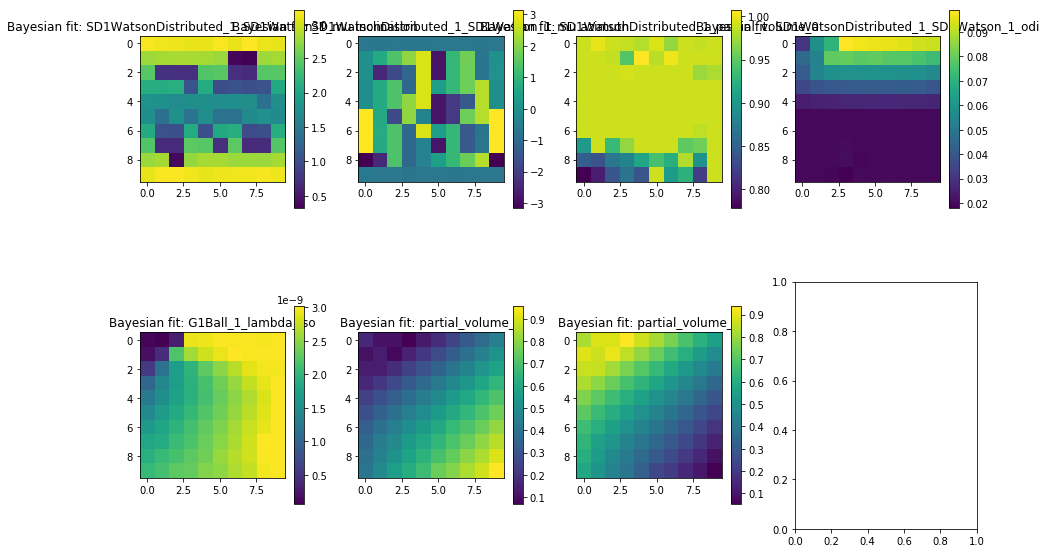

In [7]:
fig, axs = plt.subplots(2, 4, figsize=[15, 10])
axs = axs.ravel()

# l=0
# for p in range(0,nparam):
#     colormap = axs[p].imshow(bayesian_fit_maps[model.parameter_names[p]])        
    
#     fig.colorbar(colormap, ax=axs[p], shrink=0.8)
    
#     #axs[p].set_title(model.parameter_names[p])    
    
        
l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        colormap = axs[l].imshow(bayesian_fit_maps[param][...,0])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        axs[l].set_title('Bayesian fit: ' + param + ' inclination')
        l=l+1
        
        colormap = axs[l].imshow(bayesian_fit_maps[param][...,1])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        axs[l].set_title('Bayesian fit: ' + param + ' azimuth')
        l=l+1

    else: 
        colormap = axs[l].imshow(bayesian_fit_maps[param])        
    
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        axs[l].set_title('Bayesian fit: ' + param)
            
        l=l+1

    

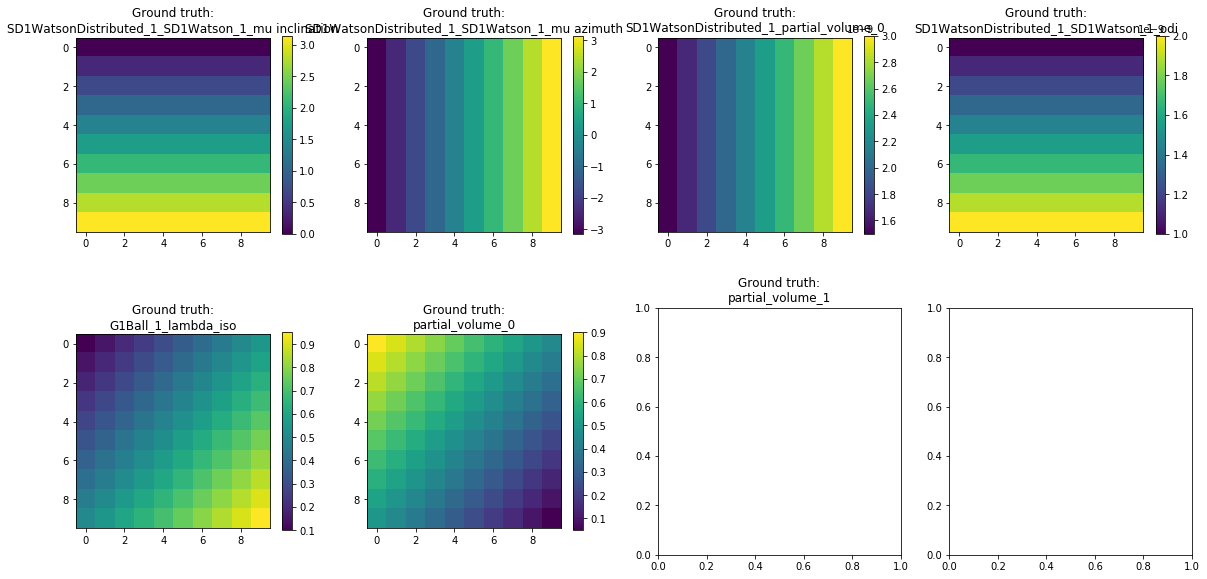

In [9]:
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
axs = axs.ravel()

nparam_groundtruth=np.shape(param_map)[2]

for p in range(0,nparam_groundtruth):
    colormap = axs[p].imshow(param_map[:,:,p])
    fig.colorbar(colormap, ax=axs[p], shrink=0.8)
    
    #axs[p].set_title(model.parameter_names[p])

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps 
        axs[l].set_title('Ground truth:\n' + param + ' inclination')
        l=l+1
        axs[l].set_title('Ground truth:\n' + param + ' azimuth')
        l=l+1
    else: 
        axs[l].set_title('Ground truth:\n' + param)
        l=l+1

    
    

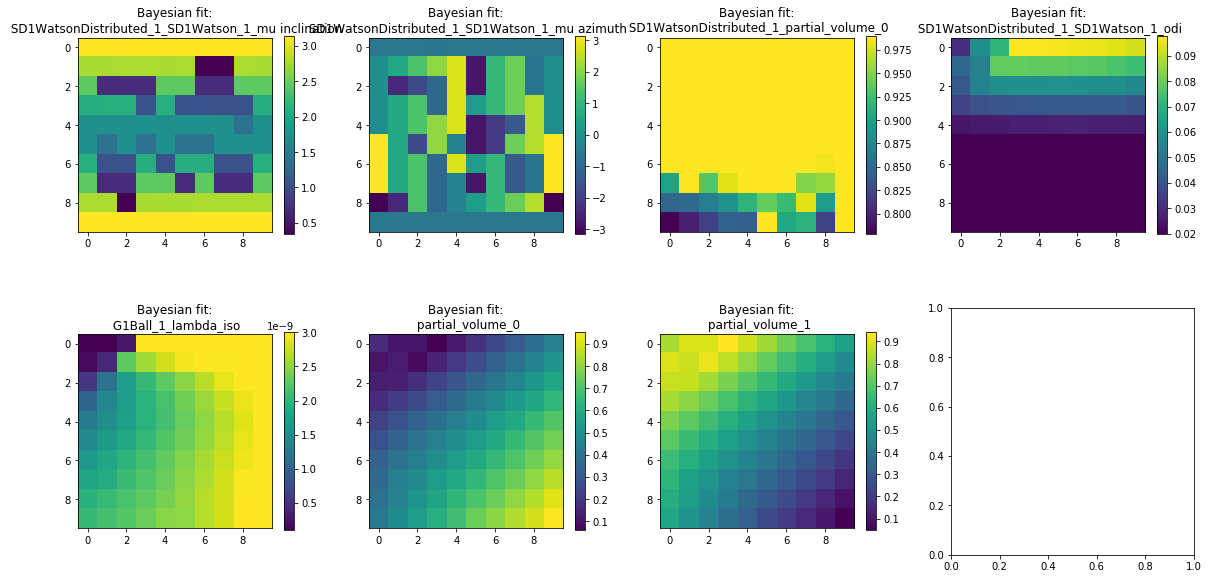

In [10]:
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
axs = axs.ravel()

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param][...,0])        
        axs[l].set_title('Bayesian fit:\n ' + param + ' inclination')
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1
        
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param][...,1])        
        axs[l].set_title('Bayesian fit:\n ' + param + ' azimuth')
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1

    else: 
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param])        
        axs[l].set_title('Bayesian fit:\n ' + param)
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
            
        l=l+1
        
        
        

    


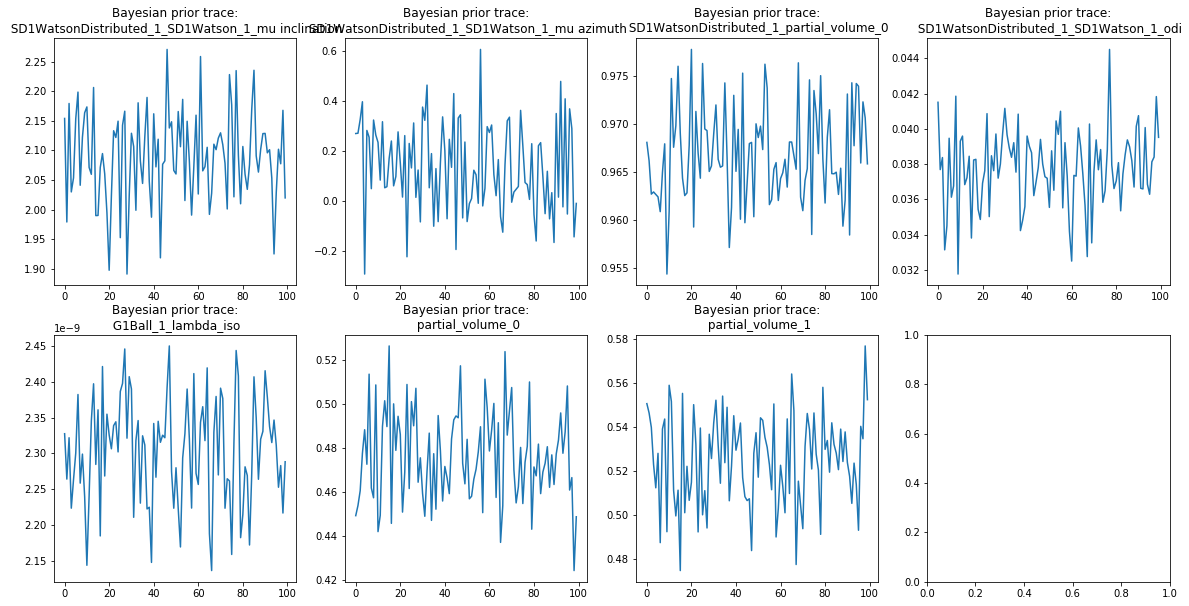

In [11]:
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
axs = axs.ravel()

for i in range(0,nparam):
    axs[i].plot(tmpgibbs[i,:])


l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps 
        axs[l].set_title('Bayesian prior trace:\n ' + param + ' inclination')
        l=l+1
        axs[l].set_title('Bayesian prior trace:\n ' + param + ' azimuth')
        l=l+1
    else: 
        axs[l].set_title('Bayesian prior trace:\n ' + param)
        l=l+1



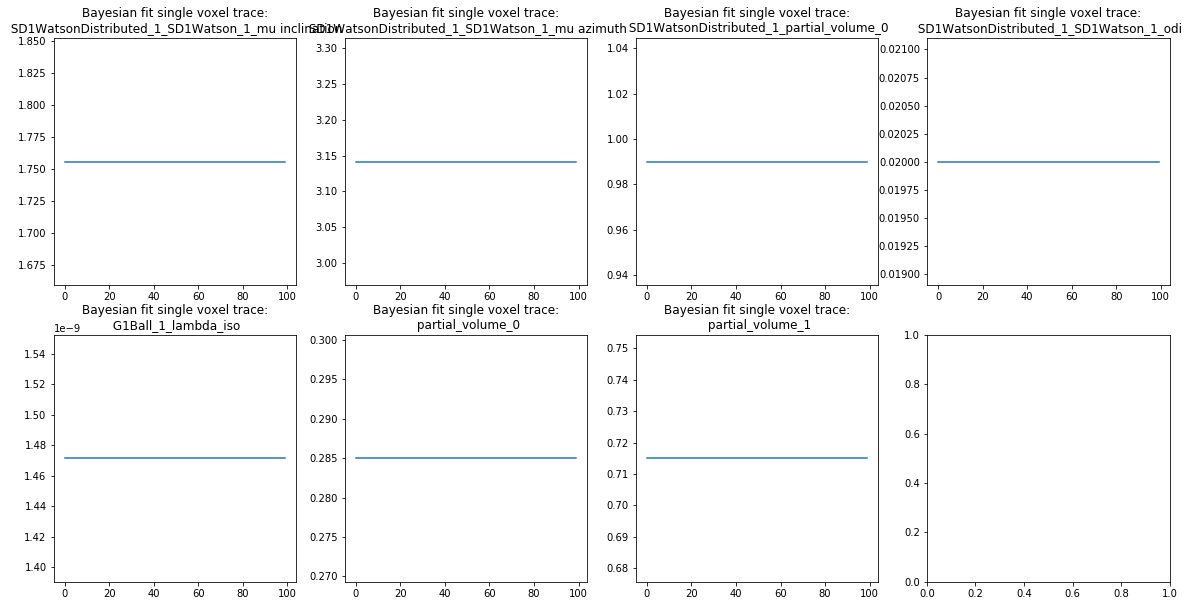

In [12]:
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
axs = axs.ravel()

voxel_index=50
for i in range(0,nparam):
    axs[i].plot(tmppar[voxel_index,:,i])
    
    

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps 
        axs[l].set_title('Bayesian fit single voxel trace:\n ' + param + ' inclination')
        l=l+1
        axs[l].set_title('Bayesian fit single voxel trace:\n ' + param + ' azimuth')
        l=l+1
    else: 
        axs[l].set_title('Bayesian fit single voxel trace:\n ' + param)
        l=l+1


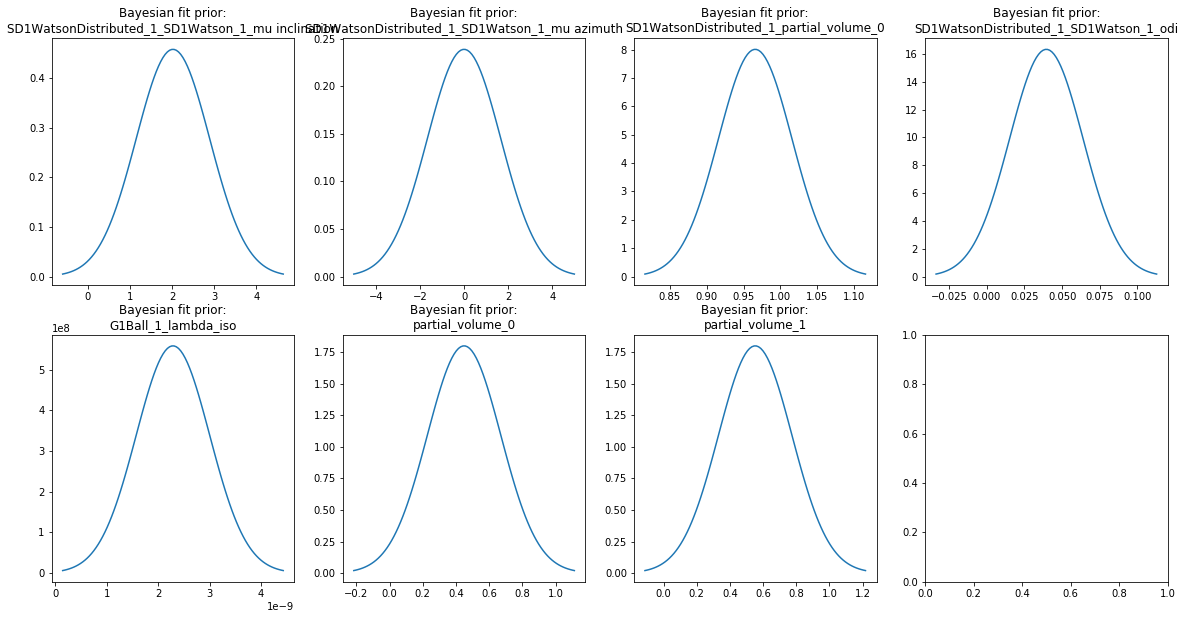

In [13]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 4, figsize=[20, 10])
axs = axs.ravel()


for i in range(0,nparam):
    marginal_mu = mu[i]
    variance = sigma[i,i]
    marginal_sigma = math.sqrt(variance)
    x = np.linspace(marginal_mu - 3*marginal_sigma, marginal_mu + 3*marginal_sigma, 100)
    axs[i].plot(x, stats.norm.pdf(x, marginal_mu, marginal_sigma))
    
    

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps 
        axs[l].set_title('Bayesian fit prior:\n' + param + ' inclination')
        l=l+1
        axs[l].set_title('Bayesian fit prior:\n' + param + ' azimuth')
        l=l+1
    else: 
        axs[l].set_title('Bayesian fit prior:\n' + param)
        l=l+1
